In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from tensorflow.keras.utils import normalize

from tensorflow.keras.layers import Input,LeakyReLU

from tensorflow.keras.initializers import he_normal

import gc
import random
import time

In [2]:
%load_ext tensorboard

In [3]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(21)

## Leitura dos dados

In [4]:
dataPath = r'D:\14--OneDrive\OneDrive\ML-SEA-2021\Rede_Teste_2'
npzFname = 'training_data.npz'

In [5]:
npz = np.load(os.path.join(dataPath, npzFname))

In [6]:
X_TRAIN = npz['X_TRAIN']
Y_TRAIN = npz['Y_TRAIN']

X_TEST = npz['X_TEST']
Y_TEST = npz['Y_TEST']

In [7]:
m_train = X_TRAIN.shape[0]
m_test = X_TEST.shape[0]
n_inp = X_TRAIN.shape[1]
n_out = Y_TRAIN.shape[1]
print('{:>30}{:8}'.format('Number of TRAINING samples:', m_train))
print('{:>30}{:8}'.format('Number of TEST samples:', m_test))
print('{:>30}{:8}'.format('Number of features:', n_inp))
print('{:>30}{:8}'.format('Number of labels:', n_out))

   Number of TRAINING samples:    8108
       Number of TEST samples:    8108
           Number of features:       8
             Number of labels:       5


## Normalização dos dados

In [8]:
class normalizer:
    
    def __init__(self):       
        pass
    
    def set_norm(self, A, axis=0):
        self.mean = np.mean(A, axis=axis)
        self.std = np.std(A, axis=axis)
        
    def normalize(self, A):
        return (A - self.mean) / self.std
    
    def denormalize(self, A):
        return A * self.std + self.mean

In [9]:
inp_normalizer = normalizer()
inp_normalizer.set_norm(X_TRAIN)

out_normalizer = normalizer()
out_normalizer.set_norm(Y_TRAIN)

X_TRAIN_norm = inp_normalizer.normalize(X_TRAIN)
Y_TRAIN_norm = out_normalizer.normalize(Y_TRAIN)
X_TEST_norm = inp_normalizer.normalize(X_TEST)
Y_TEST_norm = out_normalizer.normalize(Y_TEST)

In [10]:
out_normalizer.mean

array([91727.82561003, 51682.25855433, 16066.89280739,   281.42319031,
       36731.74642329])

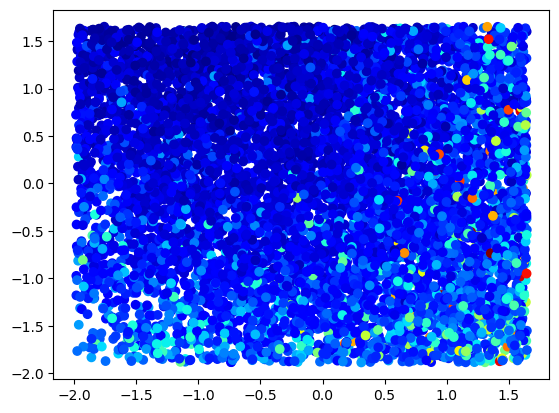

In [11]:
import matplotlib.pyplot as plt
plt.scatter(X_TRAIN_norm[:,0], X_TRAIN_norm[:,1], c=Y_TRAIN_norm[:,0], cmap='jet')
plt.show()

## Montagem do modelo

In [12]:
def get_nn(layers, lr, batchNorm=False, activ='tanh', decay=0.2, n_inp=n_inp, n_out=n_out):

    inp = Input(shape=(n_inp,))

    n_prev = n_inp

    x = inp
    
    #l2_reg = tf.keras.regularizers.L2(l2=0.01)

    for n_layer in layers:
        if batchNorm:
            x = BatchNormalization(axis=-1, momentum=0.90, epsilon=1.0e-8, beta_initializer='zeros',
                                   gamma_initializer=he_normal(seed=1), moving_mean_initializer='zeros',
                                   moving_variance_initializer='ones')(x)          
        x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
                  kernel_initializer=he_normal(seed=1), bias_initializer='zeros')(x) 
        if activ == 'LeakyReLU':
            x = LeakyReLU(alpha=0.05)(x)
        else:
            x = Activation(activ)(x)
        
        n_prev = n_layer

    x = Dense(n_out, input_dim=n_prev, use_bias = True, 
              kernel_initializer=he_normal(seed=1), bias_initializer='zeros')(x)
    output = Activation('linear')(x)

    adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1.e-8, decay=decay, amsgrad=False)

    metric1 = metrics.MeanSquaredError(name='mse', dtype=None)
    metric2 = metrics.MeanAbsolutePercentageError(name='mape', dtype=None)

    model = Model(inp,output)

    model.compile(loss='mse',
                  optimizer=adam,
                  metrics = [metric2])
    
    return model

In [13]:
# force GPU (make GPU visible)
# note: does not work without restarting the kernel, otherwise:
# "Visible devices cannot be modified after being initialized"
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
#tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Treinamento

In [14]:
#log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit/model_full2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

abs_log_dir = os.path.abspath(log_dir)
print('conda activate tf_gpu')
print('tensorboard --logdir="{}"'.format(abs_log_dir))

conda activate tf_gpu
tensorboard --logdir="C:\Users\renat\logs\fit\model_full2"


In [15]:
try:
    rmtree(abs_log_dir)
except Exception as e:
    print(e)

name 'rmtree' is not defined


In [19]:
start_time = time.time()

nn = get_nn([16*7]*7, 0.02, batchNorm=True, activ='tanh', decay=0.01)
epochs = 100
batch_size = 256

bcompile_time = time.time()
print('Model build and compile: {:.1f} seconds'.format(bcompile_time-start_time))

validation_data = (X_TEST_norm, Y_TEST_norm)
#validation_data = None

Model build and compile: 0.3 seconds


In [20]:
nn.fit(X_TRAIN_norm, Y_TRAIN_norm,
          validation_data = validation_data,
          epochs=epochs,
          batch_size=batch_size,
          shuffle=True,
          verbose = 2,
          callbacks=[tensorboard_callback])

fit_time = time.time()
print('Model training: {:.1f} seconds'.format(fit_time-bcompile_time))
print('Total time: {:.1f} seconds'.format(fit_time-start_time))

Epoch 1/100
32/32 - 9s - loss: 0.4061 - mape: 282.3104 - val_loss: 0.8263 - val_mape: 448.6812
Epoch 2/100
32/32 - 1s - loss: 0.0635 - mape: 119.9891 - val_loss: 0.2808 - val_mape: 198.8137
Epoch 3/100
32/32 - 1s - loss: 0.0395 - mape: 96.3131 - val_loss: 0.0867 - val_mape: 145.1794
Epoch 4/100
32/32 - 1s - loss: 0.0392 - mape: 150.5359 - val_loss: 0.0496 - val_mape: 181.4558
Epoch 5/100
32/32 - 1s - loss: 0.0306 - mape: 86.4713 - val_loss: 0.0300 - val_mape: 129.5516
Epoch 6/100
32/32 - 1s - loss: 0.0284 - mape: 113.3349 - val_loss: 0.0527 - val_mape: 128.9213
Epoch 7/100
32/32 - 1s - loss: 0.0302 - mape: 81.7964 - val_loss: 0.0286 - val_mape: 90.3103
Epoch 8/100
32/32 - 1s - loss: 0.0282 - mape: 98.6692 - val_loss: 0.0397 - val_mape: 154.9200
Epoch 9/100
32/32 - 1s - loss: 0.0337 - mape: 88.0629 - val_loss: 0.0270 - val_mape: 75.7490
Epoch 10/100
32/32 - 1s - loss: 0.0292 - mape: 93.5602 - val_loss: 0.0240 - val_mape: 125.1170
Epoch 11/100
32/32 - 1s - loss: 0.0231 - mape: 67.5888 - 

Epoch 88/100
32/32 - 1s - loss: 0.0144 - mape: 69.5504 - val_loss: 0.0053 - val_mape: 44.7132
Epoch 89/100
32/32 - 1s - loss: 0.0135 - mape: 62.6684 - val_loss: 0.0045 - val_mape: 59.8559
Epoch 90/100
32/32 - 1s - loss: 0.0116 - mape: 51.4461 - val_loss: 0.0040 - val_mape: 30.8686
Epoch 91/100
32/32 - 1s - loss: 0.0135 - mape: 57.6686 - val_loss: 0.0048 - val_mape: 67.1276
Epoch 92/100
32/32 - 1s - loss: 0.0151 - mape: 68.1823 - val_loss: 0.0063 - val_mape: 37.3820
Epoch 93/100
32/32 - 1s - loss: 0.0138 - mape: 53.6630 - val_loss: 0.0061 - val_mape: 46.8766
Epoch 94/100
32/32 - 1s - loss: 0.0133 - mape: 56.2770 - val_loss: 0.0046 - val_mape: 34.6270
Epoch 95/100
32/32 - 1s - loss: 0.0138 - mape: 58.3919 - val_loss: 0.0050 - val_mape: 50.6599
Epoch 96/100
32/32 - 1s - loss: 0.0123 - mape: 51.7568 - val_loss: 0.0032 - val_mape: 44.0057
Epoch 97/100
32/32 - 1s - loss: 0.0139 - mape: 82.6794 - val_loss: 0.0032 - val_mape: 31.2494
Epoch 98/100
32/32 - 1s - loss: 0.0126 - mape: 82.0812 - val

In [21]:
nn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8)                 32        
_________________________________________________________________
dense_16 (Dense)             (None, 112)               1008      
_________________________________________________________________
activation_16 (Activation)   (None, 112)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 112)               448       
_________________________________________________________________
dense_17 (Dense)             (None, 112)               12656     
_________________________________________________________________
activation_17 (Activation)   (None, 112)               0   

## Avaliação do modelo

In [22]:
nn.evaluate(x=X_TEST_norm, y=Y_TEST_norm, batch_size=32, verbose=0,)

[0.004923407454043627, 48.365970611572266]

In [23]:
npzFname = 'dataset_v1_valid200_sw_ar.npz'

npz = np.load(os.path.join(dataPath, npzFname))

features = ['sw', 'ar', 'sweep', 'static_thrust', 'climb_cas', 'climb_mach', 'cruise_mach', 'cruise_alt']
#labels = ['tow', 'bow', 'w_fuel', 'd_mission', 't_mission', 'actual_cruise_alt']
labels = ['tow', 'bow', 'w_fuel', 't_mission', 'actual_cruise_alt']

valid_data = npz['data']
valid_cols = list(npz['columns'])

j = [valid_cols.index(k) for k in features]

X_VALID = valid_data[:,j]

X_VALID_norm = inp_normalizer.normalize(X_VALID)

In [24]:
%matplotlib notebook

Y_PREDICT_norm = nn.predict(X_VALID_norm)

Y_PREDICT = out_normalizer.denormalize(Y_PREDICT_norm)
    

<IPython.core.display.Javascript object>


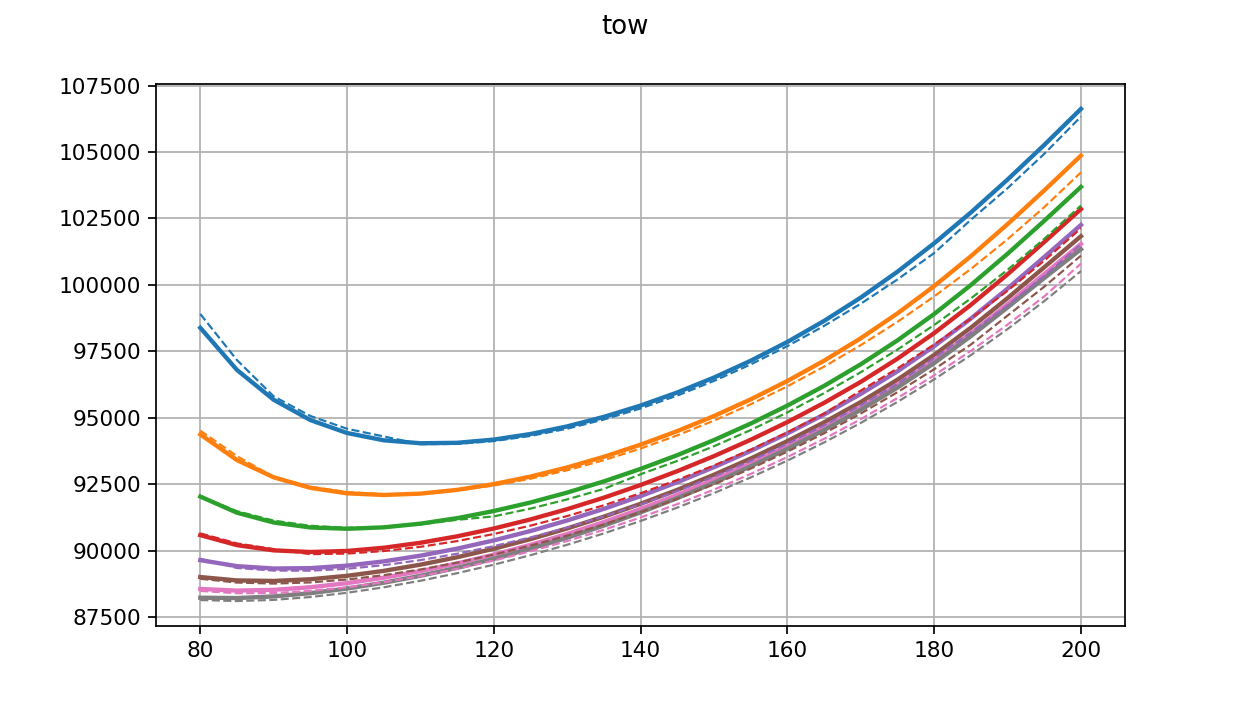

In [25]:
y_var = 'tow'
#y_var = 'bow'
#y_var = 'w_fuel'
#y_var = 't_mission'
#y_var = 'actual_cruise_alt'

j = valid_cols.index(y_var)

Y_VALID = valid_data[:,j]

j = labels.index(y_var)

XX = X_VALID[:,0].reshape((25,8))
YY = Y_PREDICT[:,j].reshape((25,8))

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(8,4.5))
plt.suptitle(y_var)
lines = ax.plot(XX, YY, linestyle='-', linewidth=2.0)
colors = [lin.get_color() for lin in lines]
for xx, yy, c in zip(XX.T, YY_V.T, colors):
    ax.plot(xx, yy, linestyle='--', linewidth=1.0, color=c)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


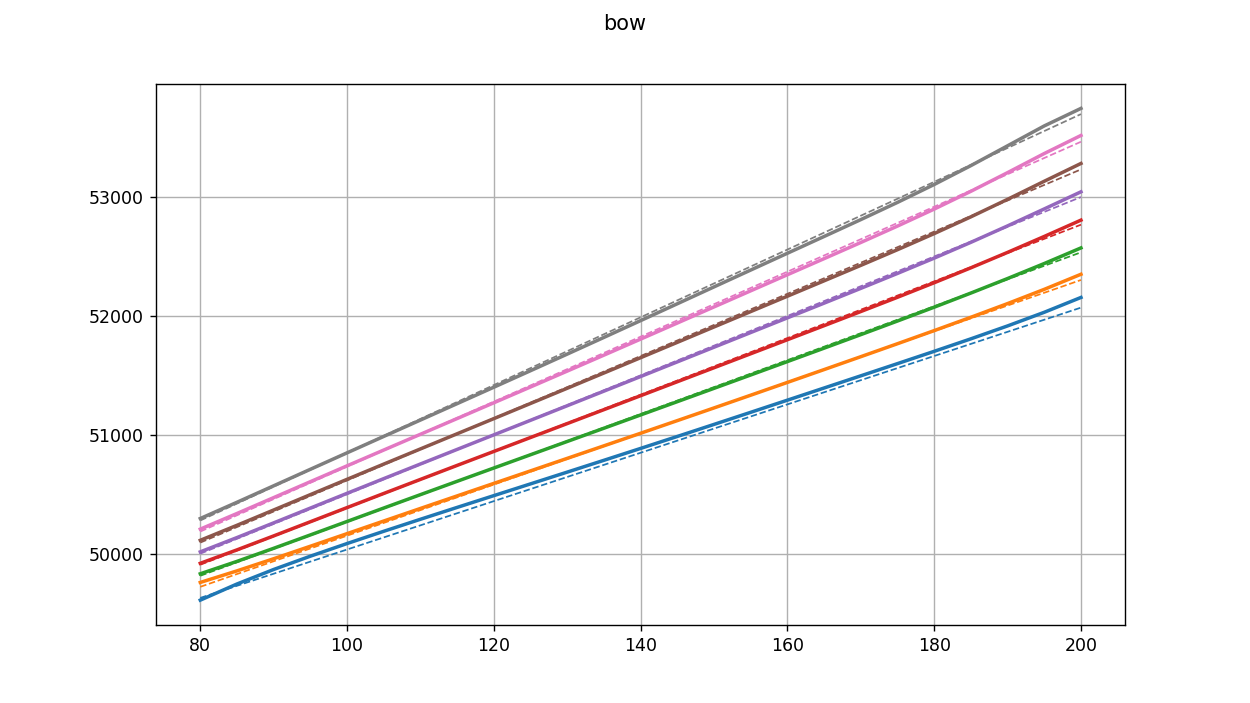

In [23]:
#y_var = 'tow'
y_var = 'bow'
#y_var = 'w_fuel'
#y_var = 't_mission'
#y_var = 'actual_cruise_alt'

j = valid_cols.index(y_var)

Y_VALID = valid_data[:,j]

j = labels.index(y_var)

XX = X_VALID[:,0].reshape((25,8))
YY = Y_PREDICT[:,j].reshape((25,8))

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(8,4.5))
plt.suptitle(y_var)
lines = ax.plot(XX, YY, linestyle='-', linewidth=2.0)
colors = [lin.get_color() for lin in lines]
for xx, yy, c in zip(XX.T, YY_V.T, colors):
    ax.plot(xx, yy, linestyle='--', linewidth=1.0, color=c)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


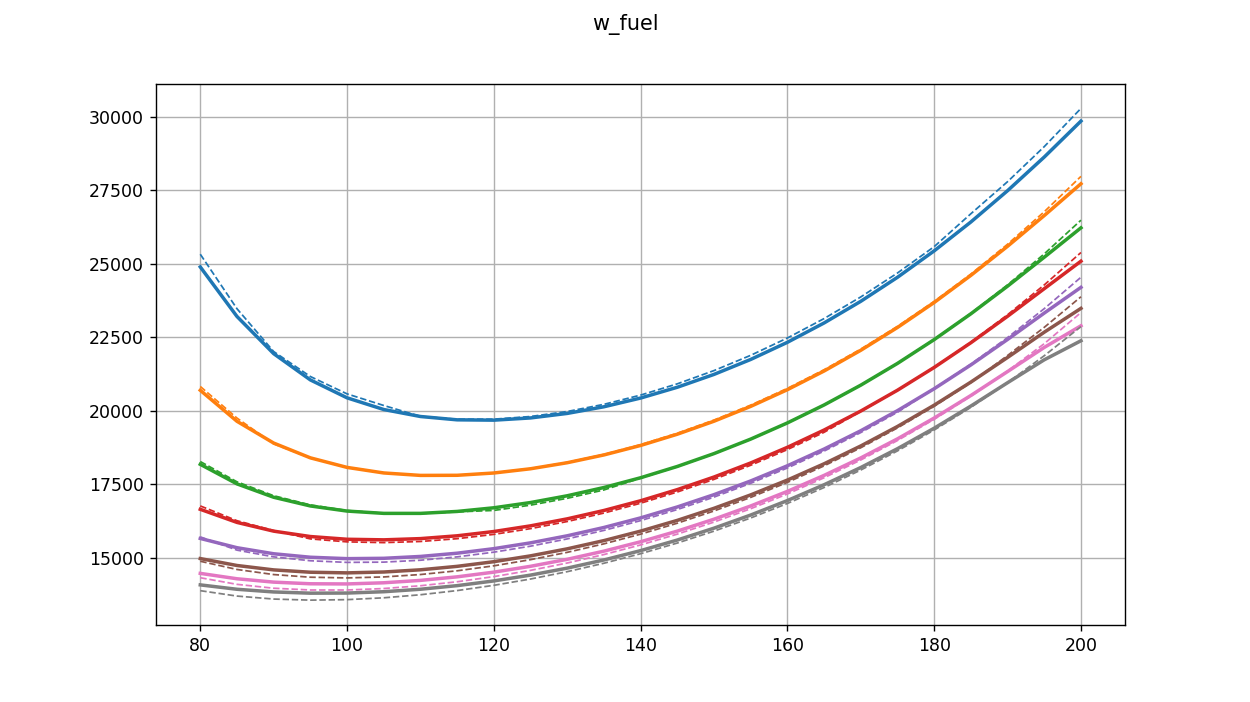

In [24]:
#y_var = 'tow'
#y_var = 'bow'
y_var = 'w_fuel'
#y_var = 't_mission'
#y_var = 'actual_cruise_alt'

j = valid_cols.index(y_var)

Y_VALID = valid_data[:,j]

j = labels.index(y_var)

XX = X_VALID[:,0].reshape((25,8))
YY = Y_PREDICT[:,j].reshape((25,8))

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(8,4.5))
plt.suptitle(y_var)
lines = ax.plot(XX, YY, linestyle='-', linewidth=2.0)
colors = [lin.get_color() for lin in lines]
for xx, yy, c in zip(XX.T, YY_V.T, colors):
    ax.plot(xx, yy, linestyle='--', linewidth=1.0, color=c)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


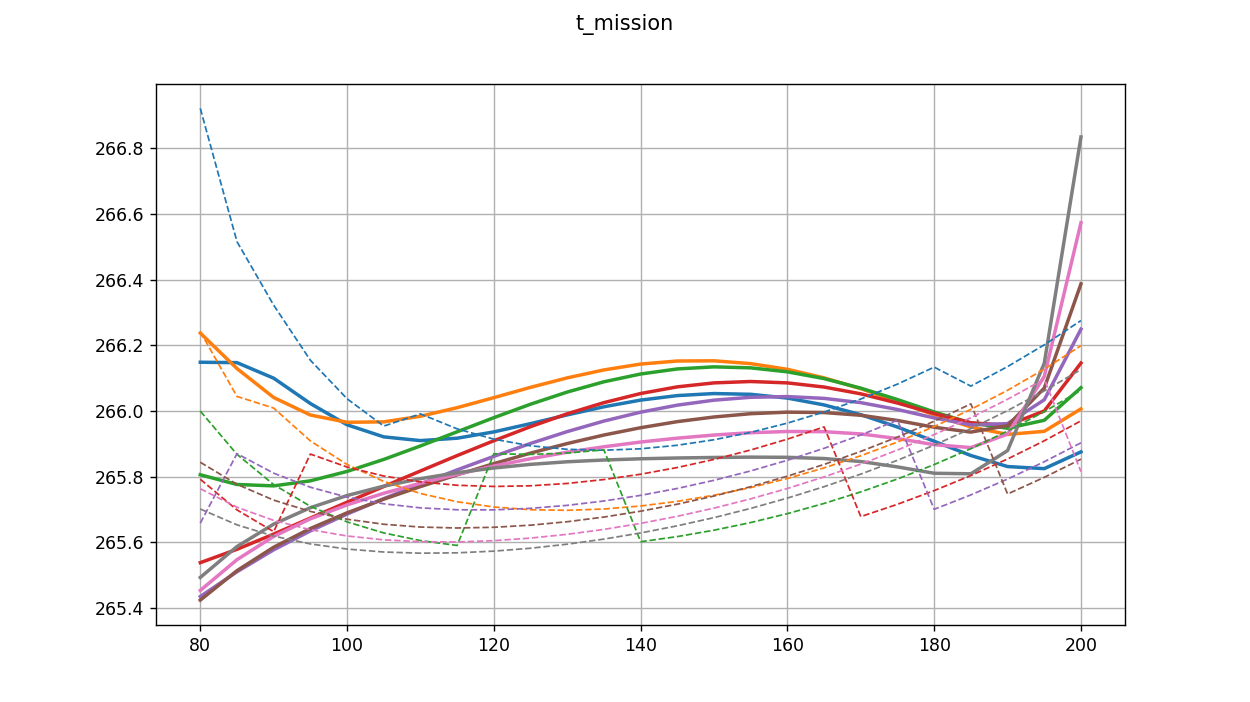

In [25]:
#y_var = 'tow'
#y_var = 'bow'
#y_var = 'w_fuel'
y_var = 't_mission'
#y_var = 'actual_cruise_alt'

j = valid_cols.index(y_var)

Y_VALID = valid_data[:,j]

j = labels.index(y_var)

XX = X_VALID[:,0].reshape((25,8))
YY = Y_PREDICT[:,j].reshape((25,8))

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(8,4.5))
plt.suptitle(y_var)
lines = ax.plot(XX, YY, linestyle='-', linewidth=2.0)
colors = [lin.get_color() for lin in lines]
for xx, yy, c in zip(XX.T, YY_V.T, colors):
    ax.plot(xx, yy, linestyle='--', linewidth=1.0, color=c)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


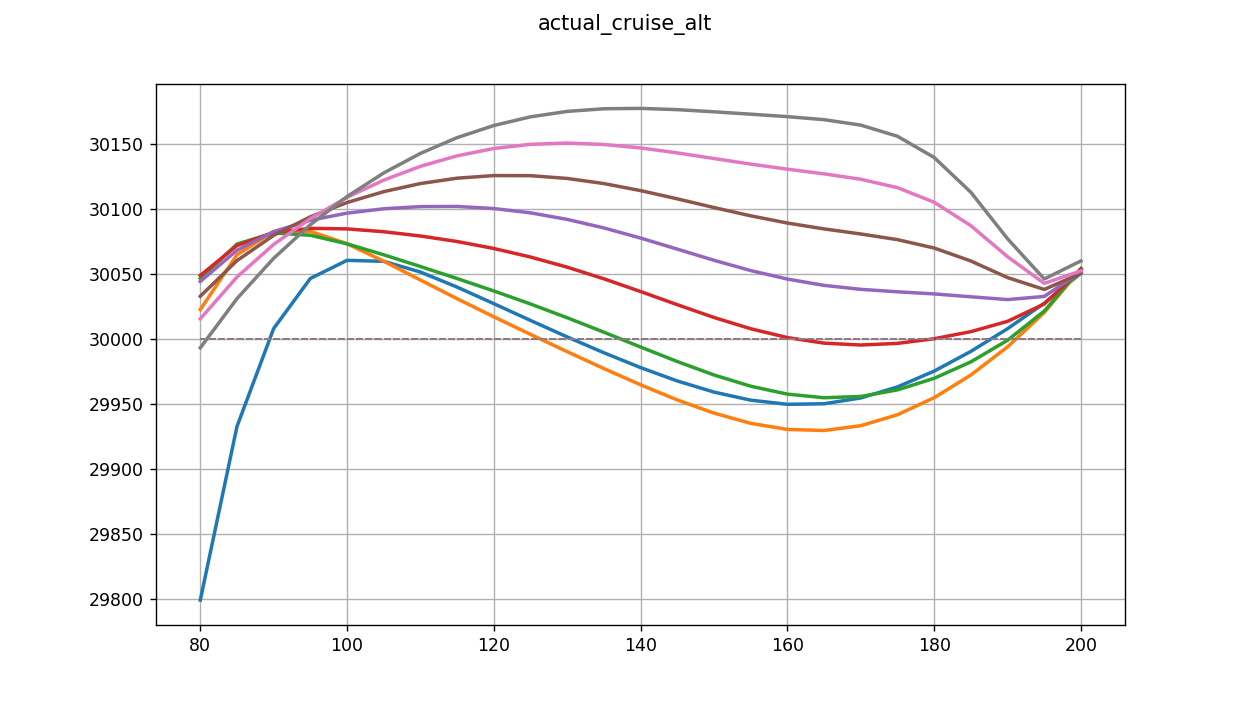

In [26]:
#y_var = 'tow'
#y_var = 'bow'
#y_var = 'w_fuel'
#y_var = 't_mission'
y_var = 'actual_cruise_alt'

j = valid_cols.index(y_var)

Y_VALID = valid_data[:,j]

j = labels.index(y_var)

XX = X_VALID[:,0].reshape((25,8))
YY = Y_PREDICT[:,j].reshape((25,8))

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(8,4.5))
plt.suptitle(y_var)
lines = ax.plot(XX, YY, linestyle='-', linewidth=2.0)
colors = [lin.get_color() for lin in lines]
for xx, yy, c in zip(XX.T, YY_V.T, colors):
    ax.plot(xx, yy, linestyle='--', linewidth=1.0, color=c)
ax.grid()
plt.show()